C:\Users\Tingjun\AppData\Local\Temp\ipykernel_16428\684785733.py:37: RuntimeWarning: overflow encountered in scalar multiply
  delta_log_V = k * (np.log(daily_vol**2) - np.log(V)) + b * np.abs(log_return)
C:\Users\Tingjun\AppData\Local\Temp\ipykernel_16428\684785733.py:41: RuntimeWarning: overflow encountered in scalar multiply
  V = V * np.exp(delta_log_V)
C:\Users\Tingjun\AppData\Local\Temp\ipykernel_16428\684785733.py:37: RuntimeWarning: invalid value encountered in scalar add
  delta_log_V = k * (np.log(daily_vol**2) - np.log(V)) + b * np.abs(log_return)
C:\Users\Tingjun\AppData\Local\Temp\ipykernel_16428\684785733.py:30: RuntimeWarning: invalid value encountered in scalar add
  log_return = daily_return - 0.5 * sigma_i**2 + sigma_i * Z


End price after 100000 days: 0.00


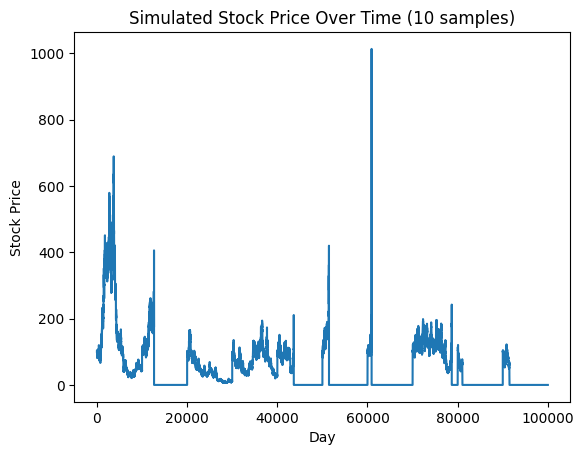

Calculated annualized volatility: 82.6768
Target annualized volatility: 0.1500


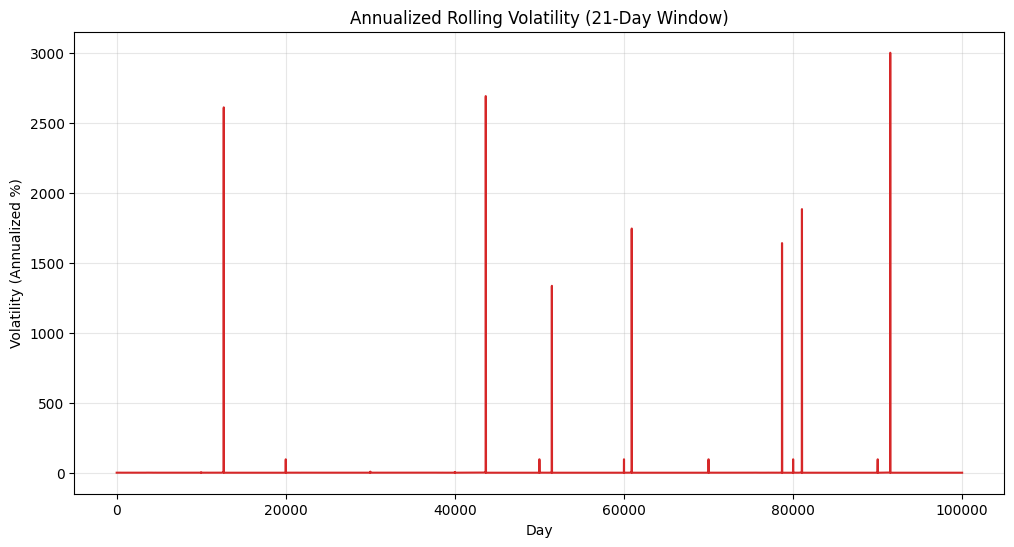

In [237]:
import numpy as np

# Model parameters
sigma_annual = 0.15   # annualized volatility
mu_annual = 0.02      # average annual return
alpha = 0.5          # parameter for mean reversion of V
b = 8.69            # parameter for V update
k = 0.1              # parameter for V update
# Non-model parameters
trading_days = 252    # number of trading days in a year
N = 10000             # number of days per sample
num_samples = 10     # number of samples
S0 = 100              # initial stock price


all_prices = []
for sample in range(num_samples):
    np.random.seed(42 + sample)  # Different seed for each sample
    
    # Daily parameters
    daily_return = mu_annual / trading_days
    daily_vol = sigma_annual / np.sqrt(trading_days)
    V = daily_vol ** 2  # initial variance (daily)

    # Simulate stock prices with adaptive volatility starting from day 3
    prices = [S0]
    for i in range(1, N):
        sigma_i = np.sqrt(V)
        Z = np.random.normal(0, 1)
        log_return = daily_return - 0.5 * sigma_i**2 + sigma_i * Z
        new_price = prices[-1] * np.exp(log_return)
        if not np.isfinite(new_price) or new_price <= 0:
            new_price = 1e-10  # reset to small positive value to prevent NaN/inf
        prices.append(new_price)

        # Calculate the change in log-variance
        delta_log_V = k * (np.log(daily_vol**2) - np.log(V)) + b * np.abs(log_return)

        # Clip the delta so it can't jump too far in one day
        delta_log_V = np.clip(delta_log_V, -1.0, 1.0) 
        V = V * np.exp(delta_log_V)

        Final safety cap: don't let annualized vol exceed 200%
        max_V = (2.0**2) / 252 
        V = min(V, max_V)

    all_prices.extend(prices)

prices = all_prices  # For compatibility with second cell

# Output the end price of the last sample
print(f"End price after {N * num_samples} days: {prices[-1]:.2f}")

# Plot the stock price over time
import matplotlib.pyplot as plt 
plt.plot(range(len(prices)), prices)
plt.xlabel("Day")
plt.ylabel("Stock Price")
plt.title(f"Simulated Stock Price Over Time ({num_samples} samples)")
plt.show()

# Calculate annualized volatility over all
daily_returns = [np.log(prices[i+1] / prices[i]) for i in range(len(prices)-1)]
annualized_volatility = np.std(daily_returns) * np.sqrt(252)
print(f"Calculated annualized volatility: {annualized_volatility:.4f}")
print(f"Target annualized volatility: {sigma_annual:.4f}")

returns_series = pd.Series(daily_returns)

# Calculate 21-day rolling standard deviation
# We multiply by sqrt(252) to annualize the volatility
window = 21
rolling_vol = returns_series.rolling(window=window).std() * np.sqrt(252)

plt.figure(figsize=(12, 6))
plt.plot(rolling_vol, color='tab:red', lw=1.5)
plt.title(f'Annualized Rolling Volatility ({window}-Day Window)')
plt.xlabel('Day')
plt.ylabel('Volatility (Annualized %)')
plt.grid(alpha=0.3)
plt.show()

# Save first 100k prices to a CSV file, with columns “Day” for the day number, “Price” for stock price, and “y” for the daily returns
import pandas as pd
# Generate daily_returns safely
daily_returns = [np.nan] + list(np.diff(np.log(prices)))

df = pd.DataFrame({
    "Day": range(1, len(prices) + 1),
    "Price": prices,
    "y": daily_returns
})

# 1. Drop rows with NaNs (this removes the very first day)
df = df.dropna()

# 2. Select only the first 100,000 rows and save to CSV
df.head(100000).to_csv("simulated_prices.csv", index=False)


In [238]:
import pandas as pd

HORIZONS = 5*(np.arange(26)+1)   # does 1 to 26 weeks, can also do [5, 10, 20, 40, 80, 160]

# Create price series from simulated prices
price = pd.Series(prices, index=range(len(prices)))

ticker = "simulated"

ret = np.log(price).diff().dropna().values

rows = []
scale = np.sqrt(252)

for T in HORIZONS:
    i = 0
    while i + T <= len(ret):
        window = ret[i:i+T]     # T points
        if len(window) < T * 0.8:
            break

        x = window.sum()   # total price change over the period
        sigma = np.std(window, ddof=0) * scale  # use np.std to get std over period, ddof=1 means divisor is N-1
        z_raw = x / np.sqrt(T / 252.0)

        # REJECT BAD WINDOWS
        if not (np.isfinite(sigma) and sigma > 0 and np.isfinite(z_raw)):
            i += T
            continue

        rows.append({          # append row of data for this period
            "ticker": ticker,
            "date": i + T - 1,
            "T": T,
            "z_raw": float(z_raw),
            "sigma": float(sigma)
        })
        i += T

if not rows:
    print(" [no data]")
else:
    df = pd.DataFrame(rows)

    # CLEAN BEFORE DE-MEANING 
    df = df[np.isfinite(df['z_raw']) & np.isfinite(df['sigma']) & (df['sigma'] > 0)]

    # NOW de-mean safely, this step groups by ticker and T, and subtracts the group mean 
    df["z"] = df.groupby(["ticker", "T"])["z_raw"].transform(lambda g: g - g.mean())

    df = df.drop(columns="z_raw")
    df = df.dropna().reset_index(drop=True)  # Final clean

    print(f" → {len(df)} clean windows")
    display(df)

    # Split into 3 parts
    n = len(df) // 3
    part1 = df.iloc[:n]
    part2 = df.iloc[n:2*n]
    part3 = df.iloc[2*n:]

    # Save 3 small files
    part1.to_parquet("dataset_part1.parquet", compression=None)
    part2.to_parquet("dataset_part2.parquet", compression=None)
    part3.to_parquet("dataset_part3.parquet", compression=None)
    print("Saved to dataset_part1.parquet, dataset_part2.parquet, dataset_part3.parquet")

 → 38688 clean windows


,ticker,date,T,sigma,z
0,simulated,4,5,0.100029,0.178858
1,simulated,9,5,0.125637,0.188109
2,simulated,14,5,0.156258,-0.345766
3,simulated,19,5,0.125147,-0.321547
4,simulated,24,5,0.212005,-0.047887
...,...,...,...,...,...
38683,simulated,90999,130,0.260748,0.020021
38684,simulated,91129,130,0.228660,-0.044531
38685,simulated,91259,130,0.275776,-0.137789
38686,simulated,91389,130,0.274752,-0.399591


Saved to dataset_part1.parquet, dataset_part2.parquet, dataset_part3.parquet
